# This notebook is an example of:
### - How to use the yfinance to get stock market data;
### - Time series analysis

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
#load data from Brazilian stock exchange market IBOVESPA
tickers = ["^BVSP", "USDBRL=x",'petr4.sa']
stockData = web.get_data_yahoo(tickers)["Close"]
stockData = stockData.rename(columns = {'^BVSP': 'IBOV','USDBRL=x': 'DOLAR','petr4.sa':'PETR4'}, inplace = False)
stockData.head()

Symbols,IBOV,DOLAR,PETR4
Date,,,
2016-11-14,59657.0,3.3900,14.00
2016-11-15,NaN,3.4403,NaN
2016-11-16,60759.0,3.4417,14.74
2016-11-17,59770.0,3.4507,14.29
2016-11-18,59962.0,3.4324,14.52


In [4]:
stockData = stockData.reset_index()
stockData['Date'] = pd.to_datetime(stockData['Date'])
stockData['Year'] = stockData['Date'].dt.year
stockData['Month'] = stockData['Date'].dt.month

In [5]:
#check missing data in dolar exchange rate, ibovespa index and petr4 columns
cotCol =  stockData['DOLAR'].shape
ibovCol = stockData['IBOV'].shape
petrCol = stockData['PETR4'].shape

print("Missing percentage of DOLAR data {:.2f}%.".format(100*(stockData['DOLAR'].isnull().sum()/cotCol[0])))      
print("Missing percentage of IBOV data {:.2f}%.".format(100*(stockData['IBOV'].isnull().sum()/ibovCol[0])))
print("Missing percentage of PETR4 data {:.2f}%.".format(100*(stockData['PETR4'].isnull().sum()/petrCol[0])))

Missing percentage of DOLAR data 10.08%.
Missing percentage of IBOV data 15.47%.
Missing percentage of PETR4 data 14.92%.


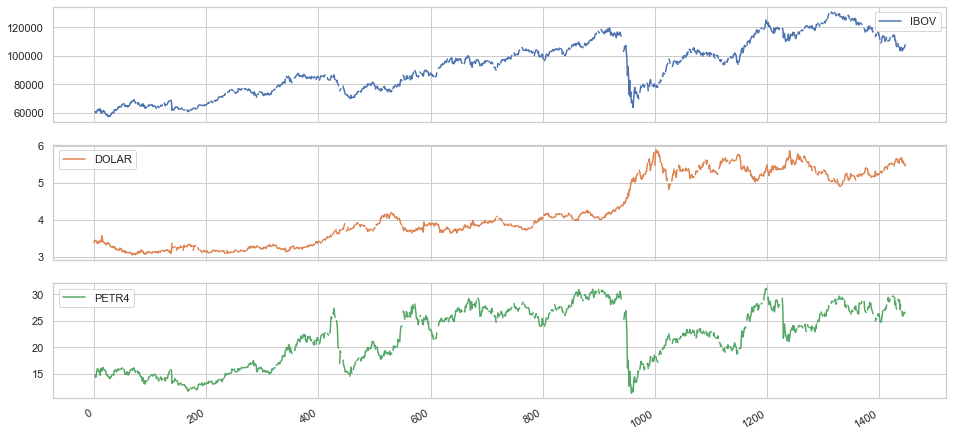

In [6]:
#visualization of missing data
sns.set_theme(style="whitegrid")
stockData[['IBOV','DOLAR', 'PETR4']].plot(subplots=True, figsize=(16, 8))
plt.show()

In [7]:
#inpute missing data with interpolation.
stockData['DOLAR'] = np.where(stockData['DOLAR'] == 0, np.nan, stockData['DOLAR'])
stockData['DOLAR'] = stockData.DOLAR.interpolate()

stockData['IBOV'] = np.where(stockData['IBOV'] == 0, np.nan, stockData['IBOV'])
stockData['IBOV'] = stockData.IBOV.interpolate()

stockData['PETR4'] = np.where(stockData['PETR4'] == 0, np.nan, stockData['PETR4'])
stockData['PETR4'] = stockData.PETR4.interpolate()

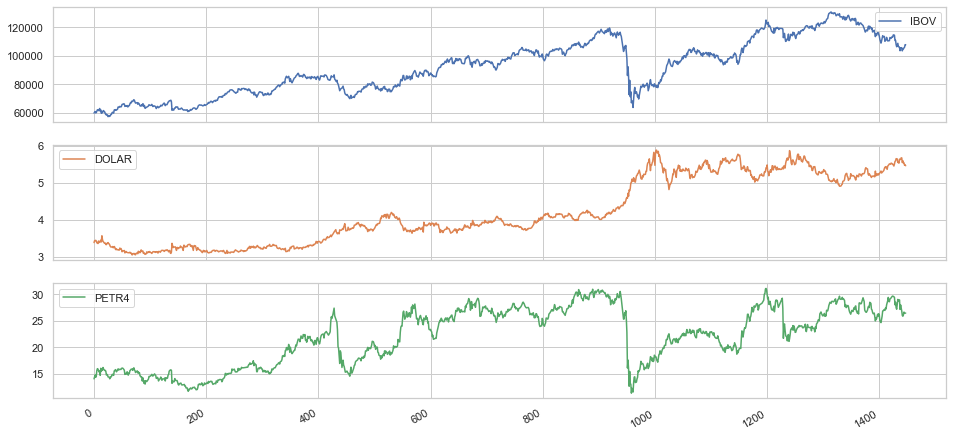

In [8]:
#visualization of data with inputted data
sns.set_theme(style="whitegrid")
stockData[['IBOV','DOLAR', 'PETR4']].plot(subplots=True, figsize=(16, 8))
plt.show()

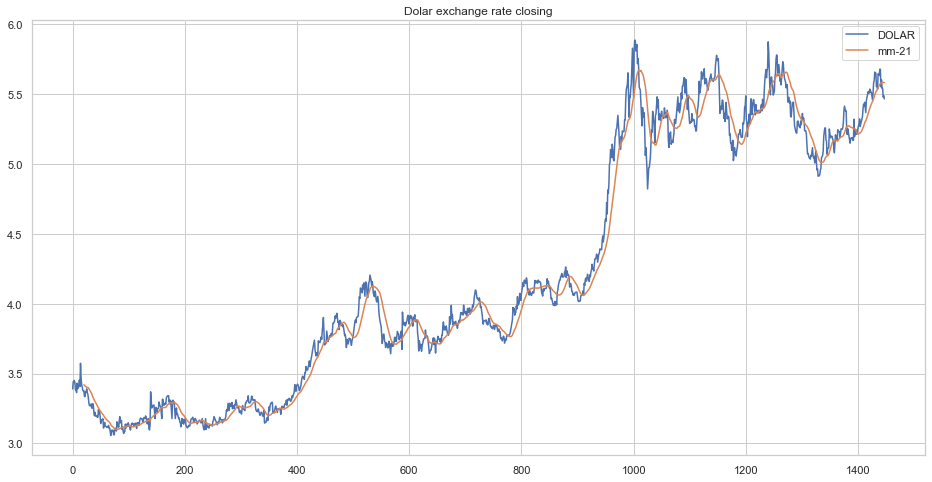

In [9]:
sns.set_theme(style="whitegrid")

stockData['DOLAR'].plot(x= stockData['Date'],subplots=False, figsize=(16, 8))
stockData['DOLAR'].rolling(21).mean().plot(label="mm-21")
# Legends
plt.title('Dolar exchange rate closing')
plt.legend()
plt.show()

### Petrobras(PETR4) stocks and moving average plots

C:\Users\felipe\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\felipe\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\felipe\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mis

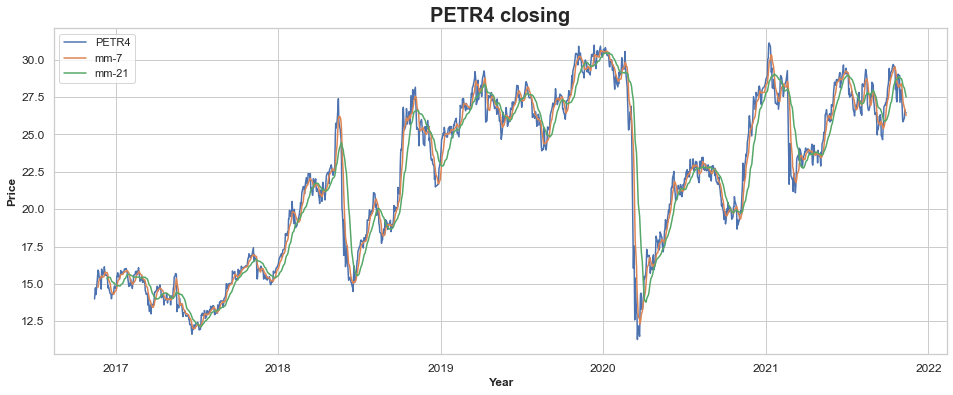

In [10]:
sns.set_theme(style="whitegrid")
# Closing time
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(stockData['Date'], stockData["PETR4"],label = 'PETR4' )
sns.lineplot(stockData['Date'], stockData["PETR4"].rolling(7).mean(),label="mm-7" )
sns.lineplot(stockData['Date'], stockData["PETR4"].rolling(21).mean(),label="mm-21" )

# Formatting
ax.set_title('PETR4 closing', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 12, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 12, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=12)
plt.tick_params(axis='x', which='major', labelsize=12)

In [11]:
stockData['Year'] = stockData['Date'].dt.year
stockData['Month'] = stockData['Date'].dt.month

In [12]:
stockData['Year'].unique()

array([2016, 2017, 2018, 2019, 2020, 2021], dtype=int64)

### Checking seasonality

C:\Users\felipe\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\felipe\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\felipe\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mis

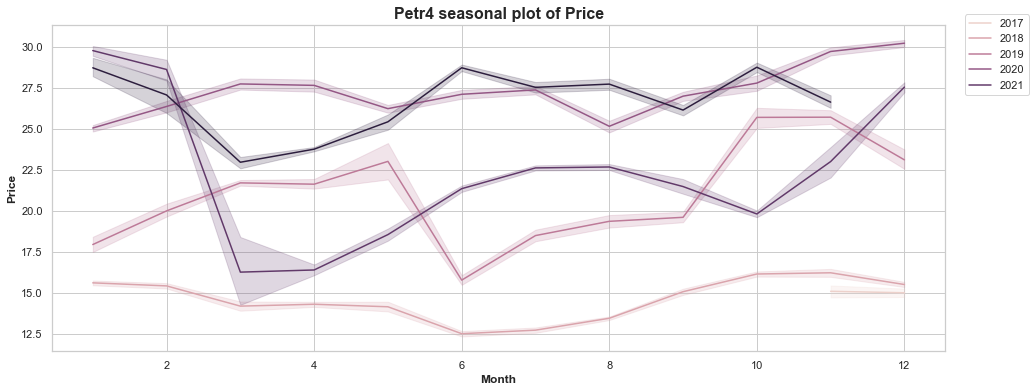

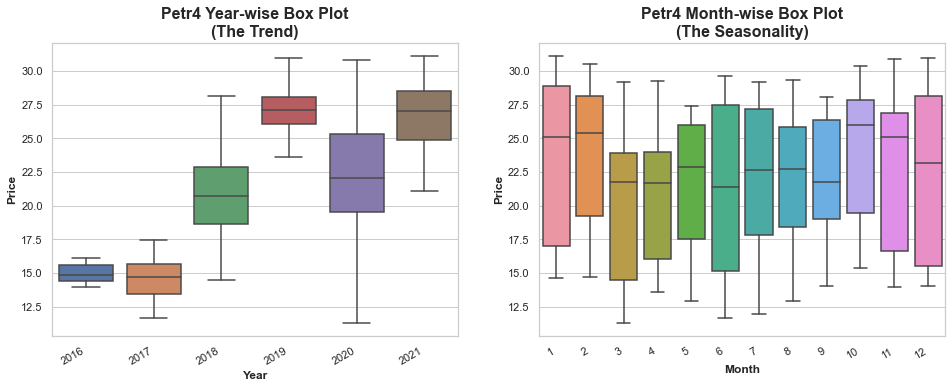

In [13]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.lineplot(stockData['Month'], stockData['PETR4'], hue = stockData['Year'])
ax.set_title('Petr4 seasonal plot of Price', fontsize = 16, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 12, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 12, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2017+i) for i in range(5)], bbox_to_anchor=(1.1, 1.05))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.boxplot(stockData['Year'], stockData['PETR4'], ax=ax[0])
ax[0].set_title('Petr4 Year-wise Box Plot\n(The Trend)', fontsize = 16, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 12, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Price', fontsize = 12, fontdict=dict(weight='bold'))

sns.boxplot(stockData['Month'], stockData['PETR4'], ax=ax[1])
ax[1].set_title('Petr4 Month-wise Box Plot\n(The Seasonality)', fontsize = 16, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 12, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Price', fontsize = 12, fontdict=dict(weight='bold'))

fig.autofmt_xdate()

C:\Users\felipe\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\felipe\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\felipe\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mis

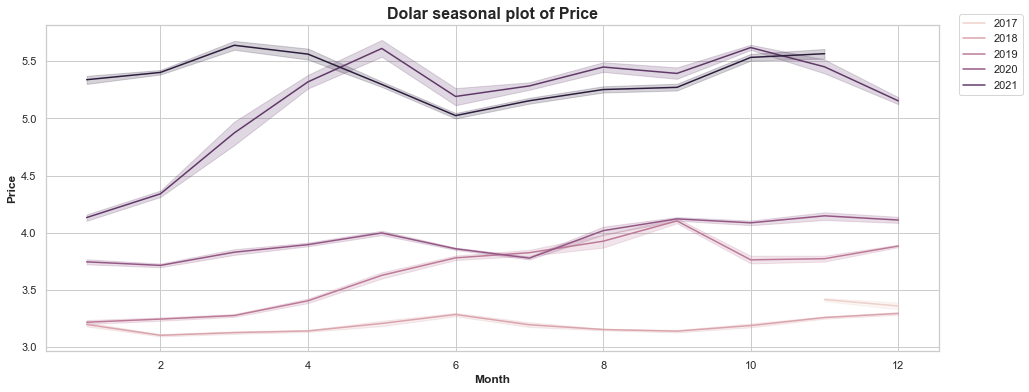

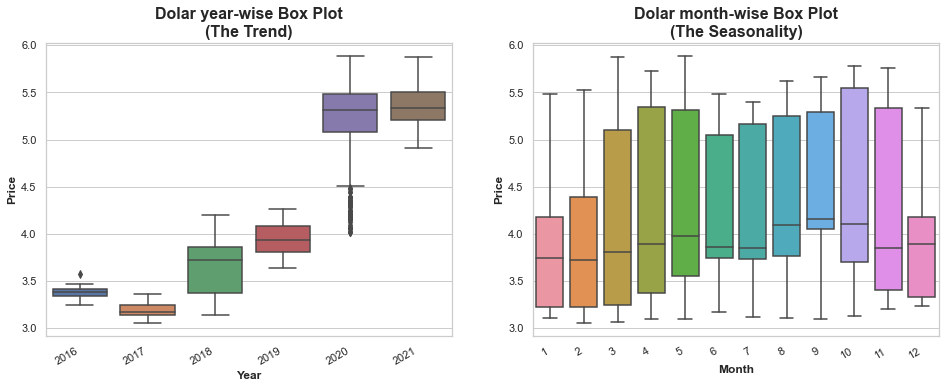

In [14]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.lineplot(stockData['Month'], stockData['DOLAR'], hue = stockData['Year'])
ax.set_title('Dolar seasonal plot of Price', fontsize = 16, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 12, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 12, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2017+i) for i in range(5)], bbox_to_anchor=(1.1, 1.05))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.boxplot(stockData['Year'], stockData['DOLAR'], ax=ax[0])
ax[0].set_title('Dolar year-wise Box Plot\n(The Trend)', fontsize = 16, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 12, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Price', fontsize = 12, fontdict=dict(weight='bold'))

sns.boxplot(stockData['Month'], stockData['DOLAR'], ax=ax[1])
ax[1].set_title('Dolar month-wise Box Plot\n(The Seasonality)', fontsize = 16, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 12, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Price', fontsize = 12, fontdict=dict(weight='bold'))

fig.autofmt_xdate()

C:\Users\felipe\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\felipe\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\felipe\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mis

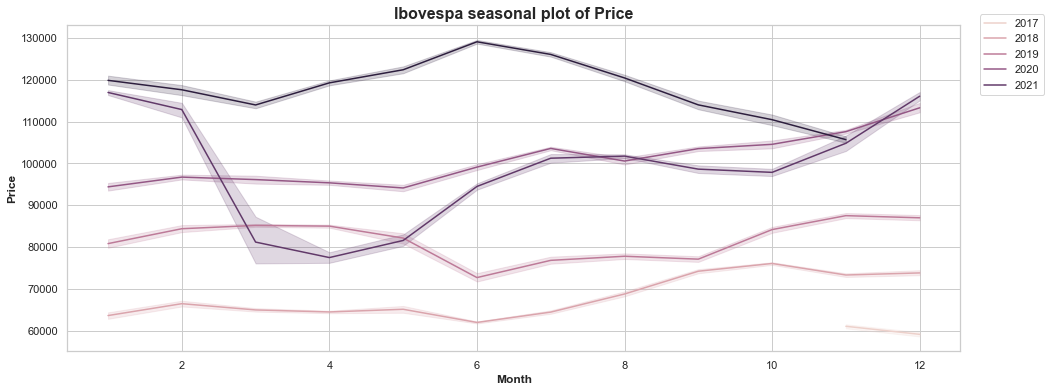

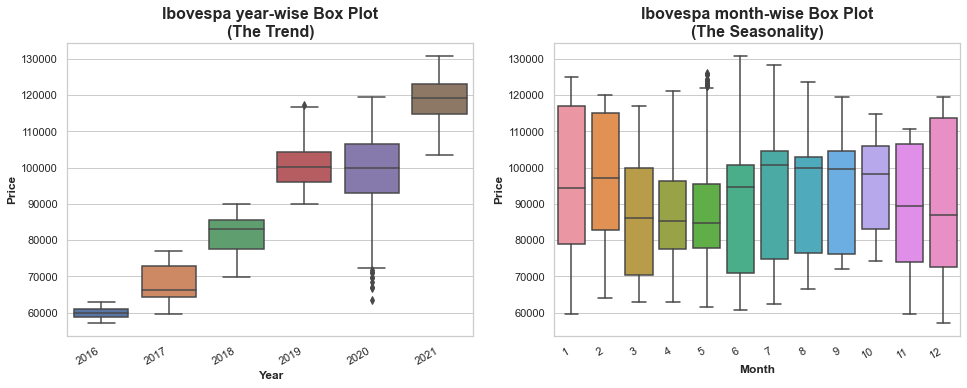

In [15]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.lineplot(stockData['Month'], stockData['IBOV'], hue = stockData['Year'])
ax.set_title('Ibovespa seasonal plot of Price', fontsize = 16, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 12, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 12, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2017+i) for i in range(5)], bbox_to_anchor=(1.1, 1.05))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.boxplot(stockData['Year'], stockData['IBOV'], ax=ax[0])
ax[0].set_title('Ibovespa year-wise Box Plot\n(The Trend)', fontsize = 16, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 12, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Price', fontsize = 12, fontdict=dict(weight='bold'))

sns.boxplot(stockData['Month'], stockData['IBOV'], ax=ax[1])
ax[1].set_title('Ibovespa month-wise Box Plot\n(The Seasonality)', fontsize = 16, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 12, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Price', fontsize = 12, fontdict=dict(weight='bold'))

fig.autofmt_xdate()

Text(0.5, 0.98, 'Open decomposition PETR4')

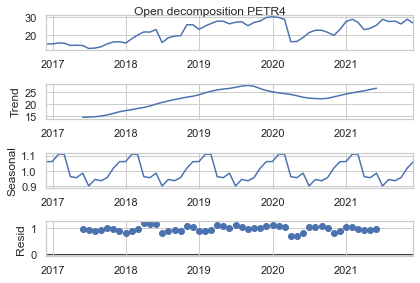

In [16]:
# Aggregating the Time Series to a monthly scaled index
y = stockData[['Date','PETR4']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Using statistical tools of statsmodel library
decomposition = seasonal_decompose(y, model='multiplicative', period = 12)
decomp = decomposition.plot()
decomp.suptitle('Open decomposition PETR4', fontsize=12)

Text(0.5, 0.98, 'Open decomposition IBOV')

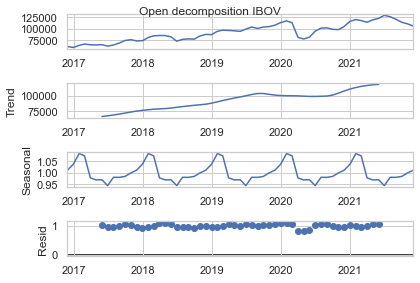

In [17]:
# Aggregating the Time Series to a monthly scaled index
y = stockData[['Date','IBOV']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Using statistical tools of statsmodel library
decomposition = seasonal_decompose(y, model='multiplicative', period = 12)
decomp = decomposition.plot()
decomp.suptitle('Open decomposition IBOV', fontsize=12)

Text(0.5, 0.98, 'Open decomposition')

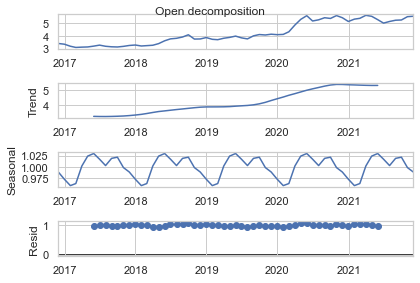

In [18]:
# Aggregating the Time Series to a monthly scaled index
y = stockData[['Date','DOLAR']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Using statistical tools of statsmodel library
decomposition = seasonal_decompose(y, model='multiplicative', period = 12)
decomp = decomposition.plot()
decomp.suptitle('Open decomposition', fontsize=12)

In [19]:
# check for stationarity
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    # .dropna() handles differenced data
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    # .to_string() removes the line "dtype: float64"
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")      

In [20]:
# Aggregating the Time Series to a monthly scaled index
y = stockData[['Date','PETR4']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()
        
adf_test(y['PETR4'],title='') 

Augmented Dickey-Fuller Test: 
ADF test statistic      -2.043698
p-value                  0.267747
# lags used              0.000000
# observations          60.000000
critical value (1%)     -3.544369
critical value (5%)     -2.911073
critical value (10%)    -2.593190
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [21]:
y = stockData[['Date','IBOV']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()
        
adf_test(y['IBOV'],title='') 

Augmented Dickey-Fuller Test: 
ADF test statistic      -1.395200
p-value                  0.584575
# lags used              3.000000
# observations          57.000000
critical value (1%)     -3.550670
critical value (5%)     -2.913766
critical value (10%)    -2.594624
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [22]:
y = stockData[['Date','DOLAR']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()
        
adf_test(y['DOLAR'],title='') 

Augmented Dickey-Fuller Test: 
ADF test statistic      -0.227782
p-value                  0.935128
# lags used              0.000000
# observations          60.000000
critical value (1%)     -3.544369
critical value (5%)     -2.911073
critical value (10%)    -2.593190
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [23]:
y = stockData[['Date','PETR4']]

Symbols,Date,PETR4
0,2016-11-14,14.000000
1,2016-11-15,14.370000
2,2016-11-16,14.740000
3,2016-11-17,14.290000
4,2016-11-18,14.520000
...,...,...
1443,2021-11-08,26.120001
1444,2021-11-09,26.639999
1445,2021-11-10,26.430000
1446,2021-11-11,26.450001


In [24]:
#diff transform and inverse
y['PETR4_diff1'] = y['PETR4'].diff()
y['reverse_diff1'] = y['PETR4'].shift(1) + y['PETR4_diff1']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


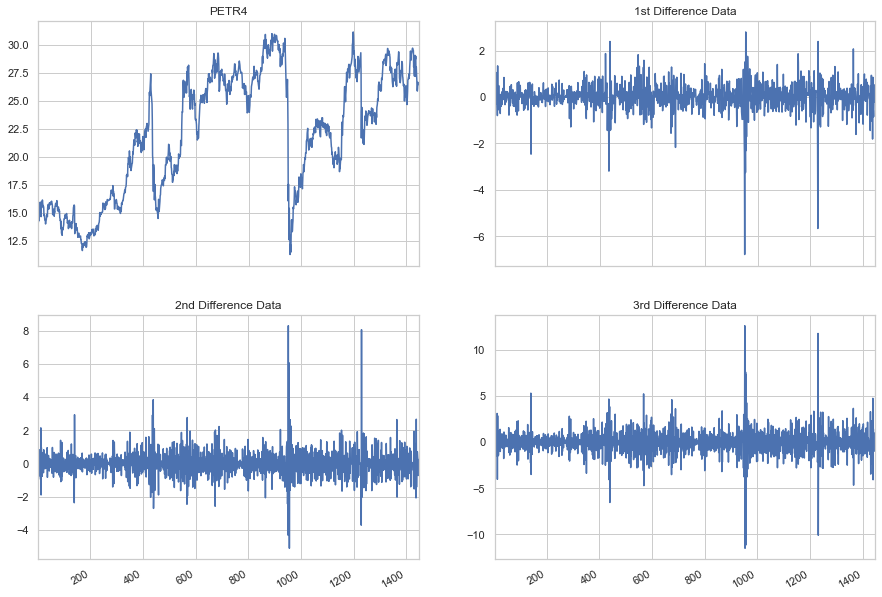

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15, 11))

y['PETR4'].plot(title="PETR4",ax=ax[0][0]).autoscale(axis='x',tight=True);
y['PETR4'].diff().plot(title="1st Difference Data",ax=ax[0][1]).autoscale(axis='x',tight=True);
y['PETR4'].diff().diff().plot(title="2nd Difference Data",ax=ax[1][0]).autoscale(axis='x',tight=True);
y['PETR4'].diff().diff().diff().plot(title="3rd Difference Data",ax=ax[1][1]).autoscale(axis='x',tight=True);
fig.autofmt_xdate()

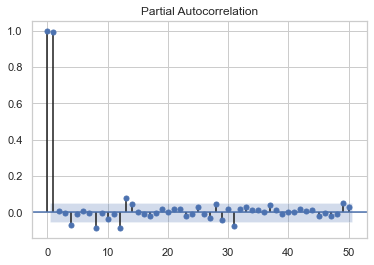

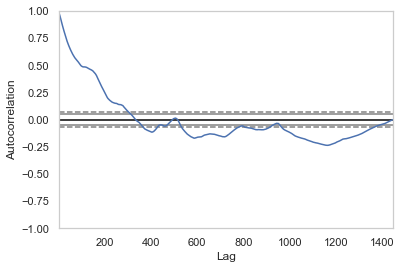

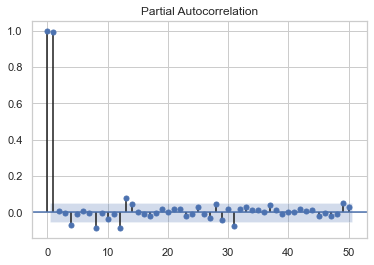

In [32]:
#Autocorrelation measures the linear relationship between lagged values of a time series, for example between  yt  and  yt−1 . 
#If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.
_ = autocorrelation_plot(stockData['PETR4'])

#Partial autocorrelations measure the linear dependence of one variable after removing the effect of other variable(s) that affect both variables.
plot_pacf(stockData['PETR4'], lags=50)

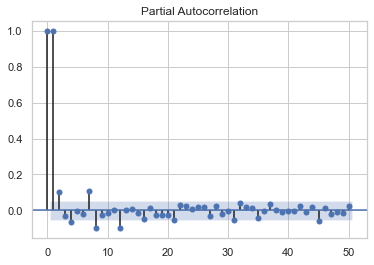

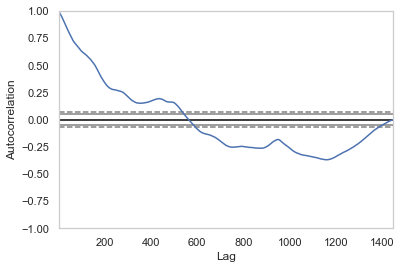

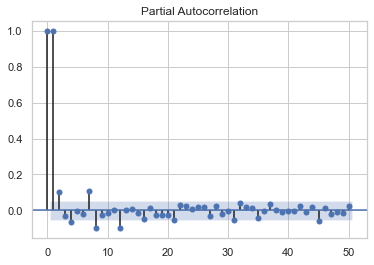

In [33]:
#Autocorrelation measures the linear relationship between lagged values of a time series, for example between  yt  and  yt−1 . 
#If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.
_ = autocorrelation_plot(stockData['IBOV'])

#Partial autocorrelations measure the linear dependence of one variable after removing the effect of other variable(s) that affect both variables.
plot_pacf(stockData['IBOV'], lags=50)

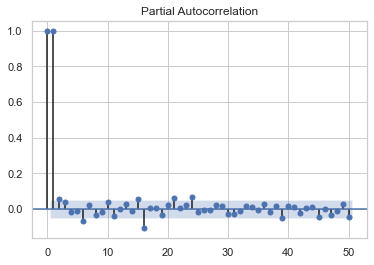

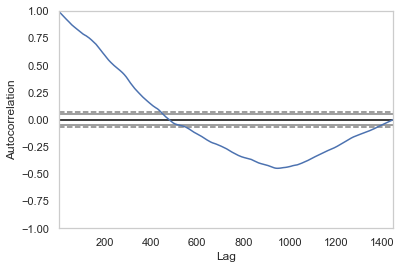

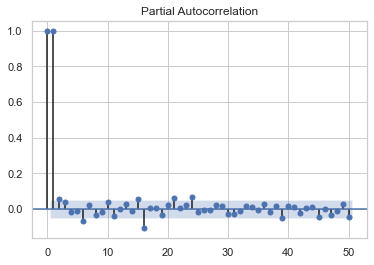

In [34]:
#Autocorrelation measures the linear relationship between lagged values of a time series, for example between  yt  and  yt−1 . 
#If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.
_ = autocorrelation_plot(stockData['DOLAR'])

#Partial autocorrelations measure the linear dependence of one variable after removing the effect of other variable(s) that affect both variables.
plot_pacf(stockData['DOLAR'], lags=50)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


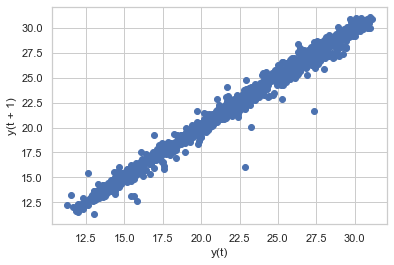

In [35]:
#A useful type of plot to explore the relationship between each observation and a lag of that observation is called the scatter plot.
#It plots the observation at time t on the x-axis and the lag1 observation (t-1) on the y-axis
lag_plot(stockData['PETR4'])

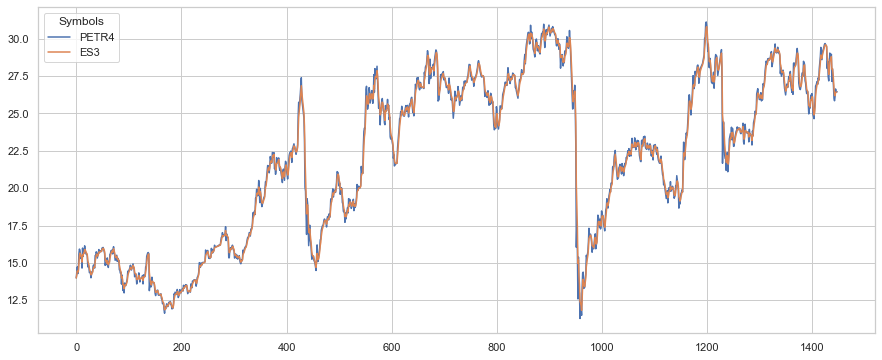

In [36]:
#Exponential Smoothing
#Exponential smoothing assigns exponentially decreasing weights for newest to oldest observations.
#In other words, the older the data, the less priority (“weight”) the data is given. Newer data is seen as more relevant and is assigned more weight
# 0 < alpha < 1
#Exponential smoothing is usually used to make short term forecasts, as longer term forecasts using this technique can be quite unreliable.
# Setting parameters value
span = 3
# Weights of observations
alpha = 2/(span+1)

# Plot Simple exponential smoothing
stockData['ES3'] = SimpleExpSmoothing(stockData['PETR4']).fit(smoothing_level = alpha, optimized = False).fittedvalues.shift(-1)
stockData[['PETR4','ES3']].plot(figsize=(15,6));

In [138]:
y1= stockData[stockData['Date']>'2020-1-1' ]

C:\Users\felipe\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\felipe\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


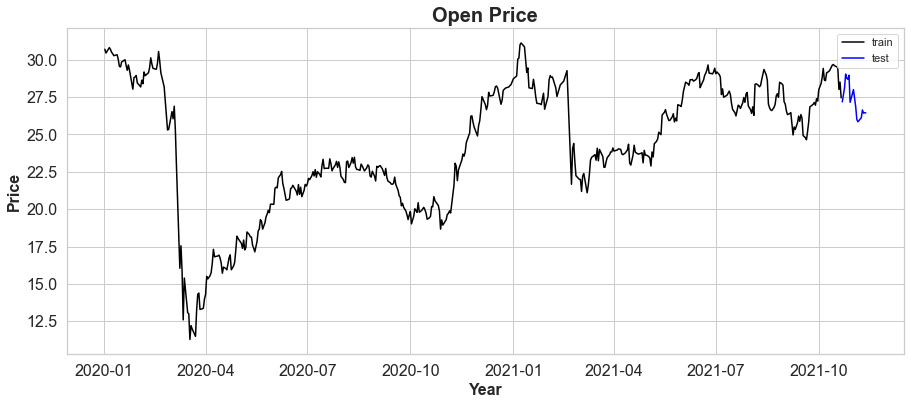

In [148]:
# Split data into train and validation set 90/10

train, val = y1[['Date','PETR4']][:int(len(y1[['Date','PETR4']])*0.97)], y1[['Date','PETR4']][int(len(y1[['Date','PETR4']])*0.97):]

# Index disappeared, put them back
val = val.set_index('Date', drop=False)
train = train.set_index('Date', drop=False)

# Line plot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(train['Date'], train['PETR4'], color = 'black')
sns.lineplot(val['Date'], val['PETR4'], color = 'blue')

# Formatting
ax.set_title('Open Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))

In [149]:
%%time
model_autoARIMA = auto_arima(train['PETR4'].dropna())

""", 
                             start_p = 0, 
                             start_q = 0,
                             test = 'adf', # use adftest to find optimal 'd'
                             max_p = 3,
                             max_q = 3, # maximum p and q
                             m = 7, # frequency of series
                             seasonal = False,
                             start_P = 0, 
                             D = 0, 
                             trace = True,
                             error_action = 'ignore',  
                             stepwise = True
"""

print(model_autoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  527
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -562.292
Date:                Fri, 12 Nov 2021   AIC                           1126.584
Time:                        16:35:13   BIC                           1130.850
Sample:                             0   HQIC                          1128.254
                                - 527                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.4966      0.008     59.269      0.000       0.480       0.513
Ljung-Box (Q):                       54.64   Jarque-Bera (JB):             13963.79
Prob(Q):                              0.06   Pr

In [150]:
model = ARIMA(train['PETR4'], order = (0, 1, 0))
# disp=-1: no output
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  PETR4   No. Observations:                  527
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -562.292
Date:                Fri, 12 Nov 2021   AIC                           1126.584
Time:                        16:35:26   BIC                           1130.850
Sample:                             0   HQIC                          1128.254
                                - 527                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.4966      0.008     59.269      0.000       0.480       0.513
Ljung-Box (Q):                       54.64   Jarque-Bera (JB):             13963.79
Prob(Q):                              0.06   Pr

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


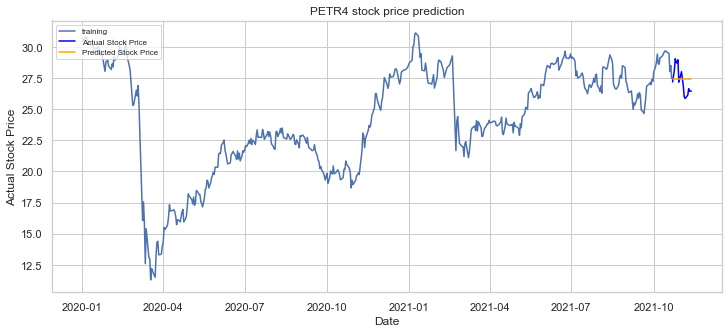

In [152]:
# Forecast 260 next observations 
fc = fitted.forecast(17, alpha=0.05)  # 95% confidence
fc_series = fc.reset_index().set_index(val['Date'], drop=True)
fc_series.drop(labels = 'index',axis = 1, inplace = True)

plt.figure(figsize=(12,5))
plt.plot(train['PETR4'], label='training')
plt.plot(val['PETR4'], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('PETR4 stock price prediction')
plt.xlabel('Date')
plt.ylabel('Actual Stock Price')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

predicted=24.002346, expected=23.700001
predicted=23.658766, expected=23.650000
predicted=23.597981, expected=23.756666
predicted=23.720689, expected=23.863333
predicted=23.877165, expected=23.969999
predicted=24.006191, expected=24.350000
predicted=24.431622, expected=23.090000
predicted=23.004719, expected=22.950001
predicted=22.809009, expected=23.615001
predicted=23.516442, expected=24.280001
predicted=24.406261, expected=23.820000
predicted=23.914009, expected=23.764999
predicted=23.804801, expected=23.709999
predicted=23.669005, expected=23.690001
predicted=23.673252, expected=23.735001
predicted=23.717841, expected=23.780001
predicted=23.785912, expected=23.100000
predicted=23.027320, expected=23.940001
predicted=23.954412, expected=23.620001
predicted=23.606930, expected=23.620001
predicted=23.670272, expected=23.525001
predicted=23.481541, expected=23.430000
predicted=23.414539, expected=22.889999
predicted=22.793328, expected=23.830000
predicted=23.848876, expected=23.500000


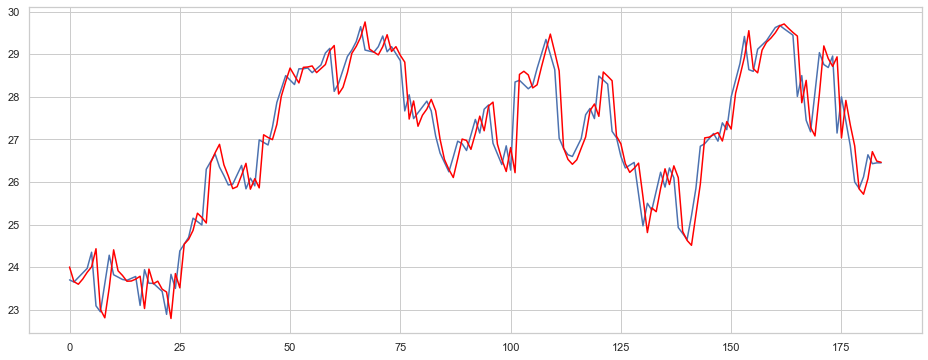

In [170]:
# split into train and test sets
X = y1['PETR4'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast(steps = 5)
    yhat = output[4]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.figure(figsize=(16,6))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

### 1-day ahead forecast with ARIMA algorithm

Test RMSE: 0.748


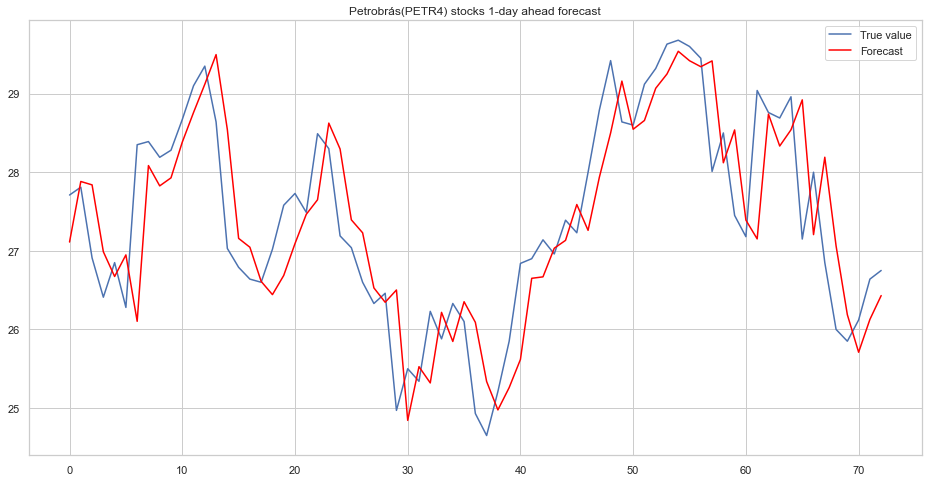

In [120]:
# split into train and test sets
X = p4["Close"].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(12,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.figure(figsize=(16, 8))
plt.plot(test, label='True value')
plt.plot(predictions, color='red', label = 'Forecast')
plt.legend()
plt.title('Petrobrás(PETR4) stocks 1-day ahead forecast')
plt.show()